## Project 2018 - "Programming For Data Analysis"

### A Notebook by: Marco Men

### Date Of Last Commit: 14th December 2018

## Introduction

In this notebook I will be choosing a  real-world phenomenon ( determination of future value ) that can be measured and for which I can collect at least 100 data points ( number of payments ) across at least four different variables ( interest rates, number of periods, periodic payment, and the present value ).
The code used is adapted from 'Numpy - Beginner's guide ( Third Edition ) by Ivan Idris.
I will investigate the types of variables involved(their distributions and relationships with each other)
I will simulate/synthesise the dataset as closely matching their properties as possible.
I will also detail my research and implement the simulation in this Jupyter notebook

https://realpython.com/python-random/


## Future Value

The future value gives the value of an asset ( or financial instrument ) at a future date, based on certain assumptions.
The future value depends on the following variables - the interest rate, the number of periods, a periodic payment, and the present value.
The formula of the future value is as follows :

$$ FV = PV(1+r)^n $$

In [2]:
# Libraries used

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

Let us imagine a loan for a mortgage today of €2200000, with an interest rate of 3 percent, and monthly payments of €800 for 108 months (9 years ). This will be represented by the simulation below.

No handles with labels found to put in legend.


Future Value -189047.68524425232


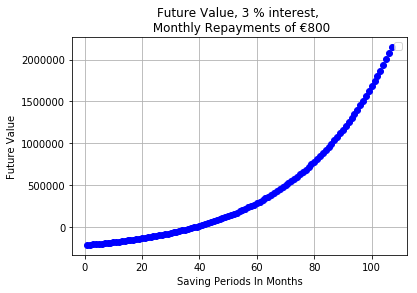

In [9]:

print("Future Value", np.fv(0.03/12, 9 * 12, -800, 220000))  

fvals = []

for i in range(1, 108) : # Number of months in 9 years-range
    fvals.append(np.fv(.03/12, i * 12, -800, 220000))
    
plt.plot(range(1, 108), fvals, 'bo')
plt.title('Future Value, 3 % interest, \n Monthly Repayments of €800')
plt.xlabel('Saving Periods In Months')
plt.ylabel('Future Value')
plt.grid()
plt.legend(loc='best')
plt.show()

The graph above shows that in 9 years from now at the monthly repayments of €800 at interest rate of 3% per annum. This person ( on the simulation ) will have paid €189,047.6852 on a loan of €220,000. The first 35 - 40 months will be spent paying accrued interest on the initial capital of the loan value. And only after that, the asset will be starting to be paid of.

What if we want to know the value of an asset today? What do we use?

## Present Values

The present value provides the value of an asset today. In Numpy pv() function is used to calculate the present value. This function mirrors fv() function and requires the same parameters - the interest rate, number of periods,the periodic payment and the future value. We will use the future value above ( €189047.6852 ).
The formula for the present value is :

$$ 

In [12]:
print ("Present Value", np.pv(0.03/12, 9 * 12, -800, 189047.6852))

Present Value -68727.51974600521


The value of the future value payment of €189047.7 in present value amount is €68,728. 
Damn the economic inflation!! That is because banks' interest rates are adjusted for risks and inflation is one of them. I was conviced that 3% interest was benevolant rate. But at €220,000 loan,that will represent €6,600 interest per year ( 220k * 0.03 ) and the repayment of €9,600 ( €800 * 12 ). The actual capital repaid for the first year will be €3,000 with the remainder €6,600 for interest.
Because we are dealing with compound interest, rather than simple interest, in the second year the capital value will be €217,000 ( €220k - €3k ).
Compound interest will be applied on this amount ( 217k * 0.03 ) giving us an interest amount of €6,510 for the second year, and so on.

## Net Present Value

The net present value is the sum of all present value cash flows. Numpy has npv() function that returns net present value cash flows. This function requires 2 arguments : the rate and an array representing the cash flow.
The formula of NPV is as follows :

$$ \sum\limits_{t=0}^{N}  {R_t \over (1+r)^t} $$

Where $R_t$ is the cash flow of a time period, $r$ is the discount rate, and $t$ is the index of the time period.

In [ ]:
We will use the information above to compute the NPV of the PV of 68,728 for 108 time periods with the discount rate of 1.03

In [22]:
# Generate 108 random values. Insert -68728 as start value

cashflows = np.random.randint(68728, size=108)
cashflows = np.insert(cashflows, 0, -68728)
print("Cashflows", cashflows)

Cashflows [-68728  15687  22067  49463   9093  39748  16121  59391  52693  57349
  36298  23437   4926  20926  31014   7049  40566  19614  37423  22963
  15464  61283  15359  48968  39110   5194   4358  49810  24480  33006
  39254  36850  29043  21763  47717  32486  46218   2977  23435  26518
  17314  50551  15776   8766  37018  32929  43163  67645  46644  49994
   4352  56444  63300  51314  25727  65926  10458  67115  15325  23551
  58407  57064  16777  36958  40722  22128  19952  67114  46296  54515
  40242  30662  57844  46117  25016  58743  14238  50152    322  49257
   8637  29357  47434  19993  50034  65752  12240  12579  28294  22956
  47372  53611  24967  22097   6850  17829  45690  45276  64636  30416
  66348  38036  61242  24046  39707  23351  16717  21327  12379]


In [23]:
NPV = np.npv(0.03,cashflows)
print("NPV", NPV)

NPV 958523.2104043585


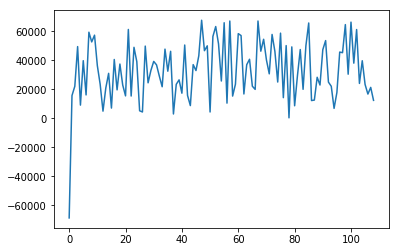

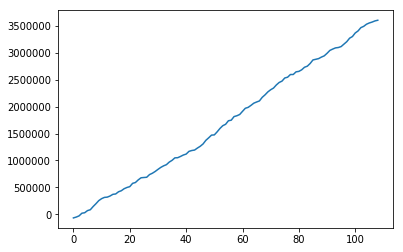

In [25]:
plt.plot(cashflows)
plt.show()


# NPV being the sum,we can use cumsum() function

npv = np.cumsum(cashflows)
plt.plot(npv)
plt.show()

The first graph will change as the cashflows generated will vary because of the numpy.random() function. For that reason I decided to plot the cumulative or CDF, because the sum will always 

In [ ]:
# for a), b) and c) the interval is 1 minute with the mean 3.4
# for c) the interval is 30 seconds- the mean will be adjusted to 3.4 / 2 = 1.7

